# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.metrics import matthews_corrcoef

# Data Loading

In [2]:
df_raw = pd.read_csv('credit_scoring.csv')

df_raw

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.008
5996,506996,40,9944385,4082038,1,477,0,0,0.017
5997,506997,28,9048532,14760384,0,450,0,0,-0.054
5998,506998,51,6843160,11774594,0,561,0,0,0.026


Dataset have 6000 rows and 9 columns.

In [3]:
df_raw.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [5]:
df_raw.isnull().sum()

application_id       0
age                  0
monthly_income       0
loan_amount          0
previous_defaults    0
credit_score         0
default              0
leak_col_good        0
leak_col_subtle      0
dtype: int64

This dataset has 0 missing values

In [6]:
df_raw.duplicated().sum()

0

This dataset has 0 duplicated data

# Exploratory Data Analysis

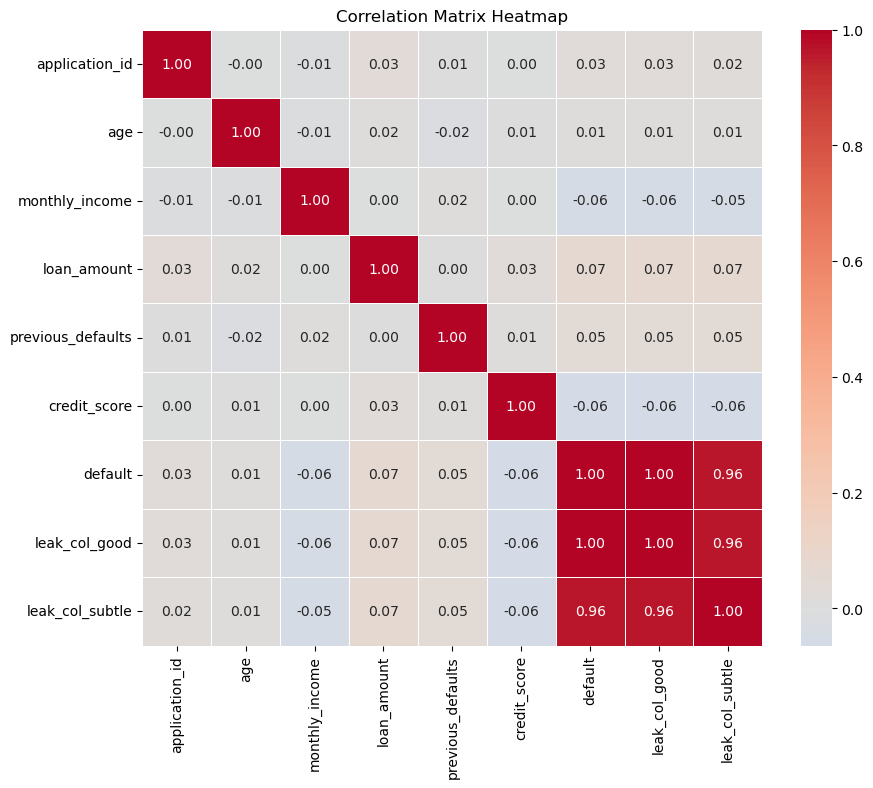

In [7]:
# Select only numeric features
numeric_features = df_raw.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Based on the heatmap, the feature `leak_col_good` and `leak_col_subtle` demonstrated abnormally high correlation with the target variable `default`. This suggests that these features may contain information closely tied to the outcome itself. Including such features could leak to data leakage, resulting in overly optimistic model that fails to generalize. Therefore, these features were removed from the dataset before training to ensure the model generalizes well.

In [8]:
df = df_raw.copy()

# Drop leakage features from dataframe
df = df_raw.drop(columns=['leak_col_good', 'leak_col_subtle'])

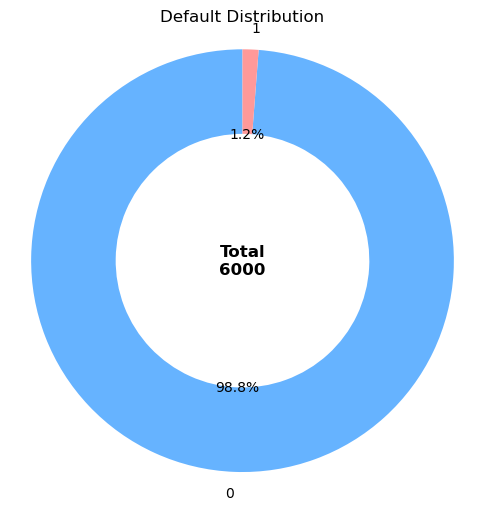

In [9]:
# Count values in the 'default' column
default_counts = df_raw['default'].value_counts()
labels = default_counts.index
sizes = default_counts.values
total = sizes.sum()

# Plot donut chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    wedgeprops={'width': 0.4}  # makes it a donut
)

# Equal aspect ratio ensures the pie is drawn as a circle
plt.axis('equal')
plt.title('Default Distribution')

# Add total count in the center
plt.text(0, 0, f'Total\n{total}', ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

Based on this donut chart, we can observe that the `default` distribution is highly imbalanced. Out of **6000 records, 98.8% (around 5,928 individuals)** fall into **Class 0**, while only **1.2% (about 72 individuals)** belong to **Class 1**. However, at this stage, we cannot interpret what **Class 0** and **Class 1** represents, whether they indicate a good or bad credit behaviour without conducting further analysis.

In [10]:
# See how previous defaults vary by default status
df_raw.groupby('default')['previous_defaults'].mean()


default
0    0.241100
1    0.452055
Name: previous_defaults, dtype: float64

In [11]:
# See how credit score varies by default status
df_raw.groupby('default')['credit_score'].mean()

default
0    577.096001
1    485.356164
Name: credit_score, dtype: float64

To better understand what each class in the `default` represents, we examined the relationship between `default` and another two feature, `previous_defaults` and `credit_score`. Here's what can we learn:

- People in **Class 0** have an average **0.24 previous defaults** and a **credit score of 577**.
- Meanwhile, **people in Class 1** averaging **0.45 previous defaults** and a **lower credit score of 458**.

These findings strongly suggest that:
- **Class 0** likely represents good customers
- **Class 1** likely represents defaulters.

It's pretty make sense considering bad customers (defaulters) are fewer in numbers and typically with lower credit scores and more past defaults. [Also another thing to note, credit score is a number typically around 300-850, that estimates how likely you are to repay a loan and make the payments on time.](https://consumer.ftc.gov/articles/credit-scores#:~:text=A%20credit%20score%20is%20a,use%20is%20the%20FICO%20score.). Since the credit score in **Class 0** is higher than **Class 1**, we could assume that **Class 1** are defaulters, supports by the number of its distribution.



<Axes: xlabel='default', ylabel='credit_score'>

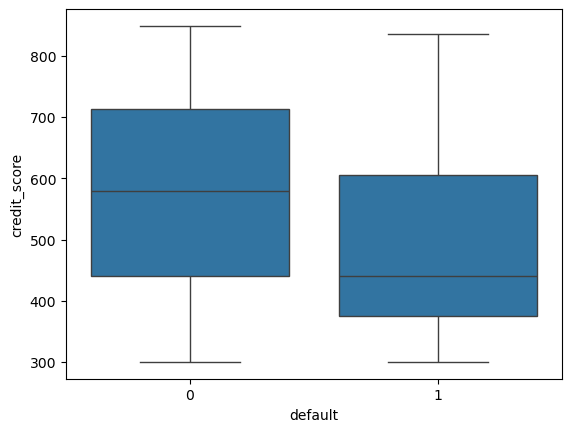

In [12]:
# Boxplot for credit score by default status
sns.boxplot(x='default', y='credit_score', data=df_raw)

Another supporting evidence that **Class 0** are good customers while **Class 1** are risky customers. We could see that the distribution of `credit_score` in **Class 0** is higher than **Class 1**.

<Axes: xlabel='default', ylabel='age'>

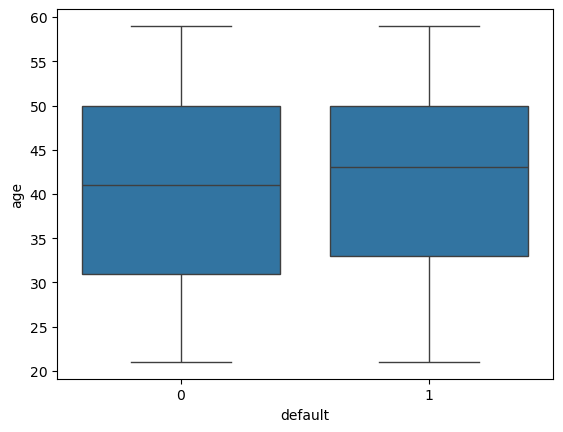

In [13]:
# Check the distribution of the 'default' column with age
sns.boxplot(x='default', y='age', data=df_raw)

In the distribution of `age` by `default` class, we observe that **Class 0** (non-default) has an age concentration between **30 to 50 years old**, with lower bound outliers ranging from **20 to 30**, and upper bound outliers extending to **50 to 60 years old**. Meanwhile, **Class 1** (default) also centers around 30-50, but with lower outliers more concentrated around **20 to early 30s**, and upper boundaries also from **50 to 60 years old**.

While the overall shape of the distributions is similar, the slight difference in the starting point may hint at subtle age-related patterns in default behavior, though not strong enough to draw definitive conclusions without further analysis.

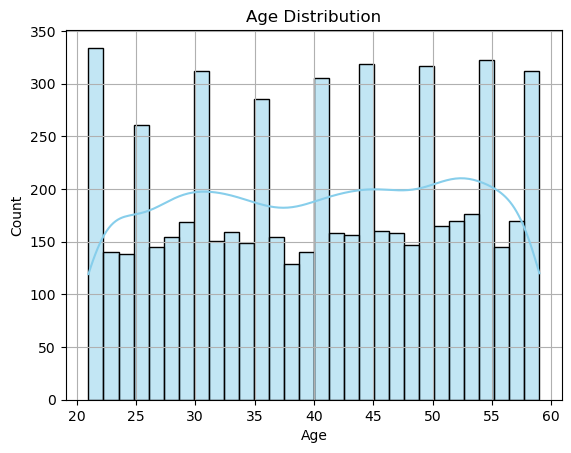

In [14]:
# Plotting the distribution of 'age'
sns.histplot(data=df_raw, x='age', kde=True, bins=30, color='skyblue', edgecolor='black')

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

This chart illustrate the age distribution of the population, with ages range from **20 to 60**. We could see that:

- The distribution is multimodal. We could see many peak in the chart.
- Highest concentration occur around ages **20** and **55-60**, with each peak exceeding 300 individuals

We can assume that the reason this happened is because young adults (around **20**) is limited in their financial resources. Young adults are often at the beginning of their career, with lower or unstable income. To bridge the problem they rely on credit cards. Also in some countries, young adults already carrying their student loan. Could be the reason why the borrow behaviour early exist.

Another thing to note that older generation is peaking really high, because some of them are no longer working but still need to cover expenses. Also, since they may have longer credit histories and better trustworthiness, making them eligible to credit.

Interestingly, we could see the dip between ages **30 to 40**. Hypothetically, these people are often have more financial stability, higher income, and potentially more savings. That's why they don't rely on credits that much, unless for something important such as **car** or **house**

In [15]:
for col in ['monthly_income','loan_amount', 'credit_score']:
    r, p = pointbiserialr(df_raw[col], df_raw['default'])
    print(f"{col}: rpb = {r:.4f}, p-value = {p:.4f}")

monthly_income: rpb = -0.0571, p-value = 0.0000
loan_amount: rpb = 0.0726, p-value = 0.0000
credit_score: rpb = -0.0635, p-value = 0.0000


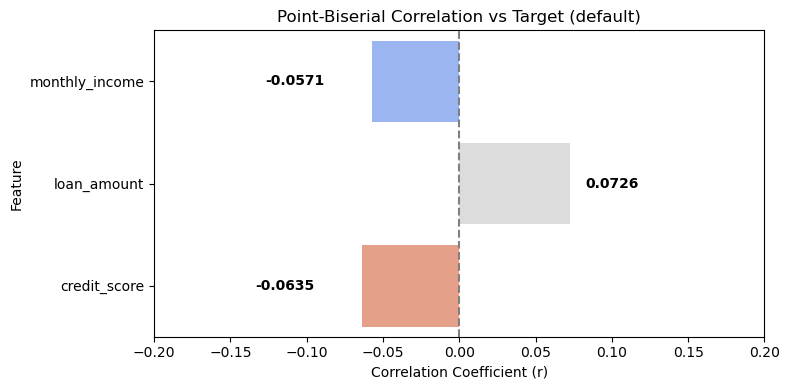

In [16]:
# Results of Point-Biserial Correlation
corr_data = {
    'Feature': ['monthly_income', 'loan_amount', 'credit_score'],
    'Point-Biserial r': [-0.0571, 0.0726, -0.0635]
}

df_corr = pd.DataFrame(corr_data)

# Plot
plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    x='Point-Biserial r',
    y='Feature',
    hue='Feature',
    data=df_corr,
    palette='coolwarm',
    legend=False,
    orient='h'
)

# Add vertical line at x=0
plt.axvline(0, color='gray', linestyle='--')

# Annotate the bars with correlation values
for index, row in df_corr.iterrows():
    value = row['Point-Biserial r']
    barplot.text(
        value + 0.01 if value >= 0 else value - 0.07,
        index,
        f"{value:.4f}",
        color='black',
        va='center',
        fontweight='bold'
    )

# Label & layout
plt.title('Point-Biserial Correlation vs Target (default)', fontsize=12)
plt.xlabel('Correlation Coefficient (r)')
plt.ylabel('Feature')
plt.xlim(-0.2, 0.2)
plt.tight_layout()
plt.show()

`monthly_income` have rbp scores -0.0571. It shows that it has **negative correlation but weak**. As monthly income increases, likelihood the default is lower. Which make sense that **higher earner less likely to default**. But since its really small, its not a strong predictor.

`loan_amount` have rbp scores 0.0726. It shows that it has **positive correlation but weak**. As loan increases, the chances of default is slightly increases. The relationship is weak but have strong correlation (p-value = 0.0000).

`credit_score` have rbp scores -0.0635. It shows that it has **negative correlation but weak**. People with higher credit score are less likely to default. However since its really weak, some people could still default while having high credit score.

In [17]:
phi = matthews_corrcoef(df_raw['previous_defaults'], df_raw['default'])
print(f"Phi Coefficient: {phi:.4f}")

Phi Coefficient: 0.0395


A phi coefficient of 0.0395 is indicates that there is a **positive correlation** between `previous_defaults` and `default`. But, since 0.0395 is close to 0, the relationship is **extremely weak**.

# Feature Engineering